# Articulation

In [6]:
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for prototyping piano-roll visualizations
import pretty_midi as pm
import librosa
import librosa.display
import mir_eval
import mir_eval.display

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')

from eval.metrics.benchmarks import *
from eval.metrics.dynamics import *
from eval.metrics.harmony import *
from eval.metrics.articulation import *
from eval.metrics.timing import *

# from config import *
from helpers.analysis import *

if not os.path.exists('../poster'):
    os.makedirs('../poster')

# To avoid the following error when running mir_eval.display.piano_roll later:
# AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'
# I rolled back matplotlib to 3.7 as per https://github.com/librosa/librosa/issues/1763#issuecomment-1742120524

print(matplotlib.__version__)
assert matplotlib.__version__ == '3.7.0', 'mir_eval.display.piano_roll needs matplotlib @ 3.7.0'

3.7.0


We will use the handcrafted example henceforth

In [ ]:
ref_midi = '../data/poster_example/mozart_example_ref.mid'
pred_midi = '../data/poster_example/mozart_example_pred.mid'

Load and visualize the example MIDI pair along with the illustration of the selected MIM: **articulation**

In [ ]:
ref_pref = pt.load_performance_midi(ref_midi)
pred_perf = pt.load_performance_midi(pred_midi)

art_metrics = articulation_metrics_from_perf(ref_pref,pred_perf)
art_metrics_64 = art_metrics[0]  # in the paper we report for spt=64 only
melody_kor_corr_64, bass_kor_corr_64, ratio_kor_corr_64, _ = art_metrics_64

print(art_metrics_64.dtype)
print(art_metrics_64)

[('melody_kor_corr', '<f8'), ('bass_kor_corr', '<f8'), ('ratio_kor_corr', '<f8'), ('pedal_threshold', '<i8')]
(0.87665525, 0.29147666, 0.77280832, 64)


break it down

In [14]:
# NOTE: since our Mozart example MIDIs don't make any use of sustain pedal, the following is irrelevant, but just in case:
ref_pref.performedparts[0].sustain_pedal_threshold = 64
pred_perf.performedparts[0].sustain_pedal_threshold = 64

ref_note_array = ref_pref.note_array()
kor_melody_ref_func, kor_bass_ref_func = get_kor_stream_funcs(ref_note_array)
ref_melody, ref_bass, ref_middle = skyline_melody_identification(note_array=ref_note_array)

onsets = np.unique(ref_note_array["onset_sec"])

melody_kor_ref = kor_melody_ref_func(onsets)
bass_kor_ref = kor_bass_ref_func(onsets)
ratio_kor_ref = melody_kor_ref / bass_kor_ref

pred_note_array = pred_perf.note_array()
kor_melody_pred_func, kor_bass_pred_func = get_kor_stream_funcs(pred_note_array)
pred_melody, pred_bass, pred_middle = skyline_melody_identification(note_array=pred_note_array)

melody_kor_pred = kor_melody_pred_func(onsets)
bass_kor_pred = kor_bass_pred_func(onsets)
ratio_kor_pred = melody_kor_pred / bass_kor_pred

melody_kor_corr = np.corrcoef(melody_kor_ref, melody_kor_pred)[0, 1]
bass_kor_corr = np.corrcoef(bass_kor_ref, bass_kor_pred)[0, 1]
ratio_kor_corr = np.corrcoef(ratio_kor_ref, ratio_kor_pred)[0, 1]

In [ ]:
print(ref_note_array.size, ref_melody.size, ref_bass.size, ref_middle.size)
print(pred_note_array.size, pred_melody.size, pred_bass.size, pred_middle.size)

66 33 32 1
73 38 19 1


Plot

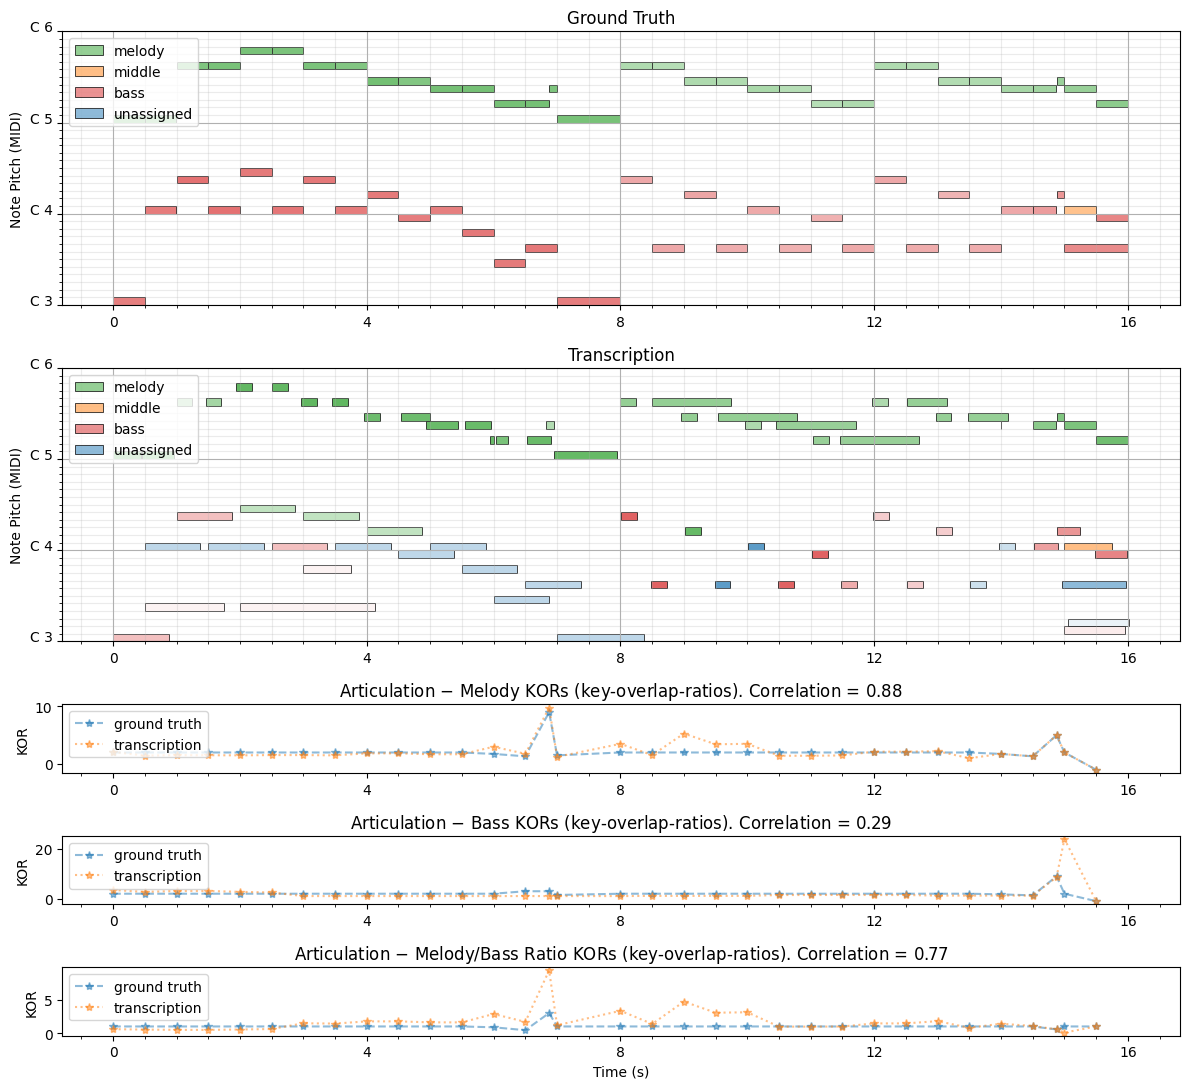

In [16]:
def get_rgba(color, alpha=0.5):
    import matplotlib.colors as mcolors
    if not hasattr(alpha, '__iter__'):
        return mcolors.to_rgb(color) + (alpha,)
    return [mcolors.to_rgb(color) + (a,) for a in alpha]

def plot_together_pianorolls_IOIs(
        ref_note_array, ref_melody, ref_bass, ref_middle,
        pred_note_array, pred_melody, pred_bass, pred_middle,
        onsets, melody_kor_ref, melody_kor_pred, bass_kor_ref, bass_kor_pred,
        title='',
        ):
    # plot the melody, bass, and middle lines with separate colors, velocity as alpha
    fig, axs = plt.subplots(5, 1, figsize=(16-4, 8+3), sharex=True, gridspec_kw={'height_ratios': [4, 4, 1, 1, 1]})
    # kwargs forwarded to Collection: https://matplotlib.org/3.7.0/api/collections_api.html#matplotlib.collections.Collection

    lw = 0.5
    alpha = 0.5

    # ground truth
    ax = axs[0]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    mir_eval.display.piano_roll([], midi=[],
        label='middle', facecolor=get_rgba('tab:orange', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_middle:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:orange', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    mir_eval.display.piano_roll([], midi=[],
        label='bass', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_bass:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    ref_unassigned = [note for note in ref_note_array if (note not in ref_melody) and (note not in ref_middle) and (note not in ref_bass)]
    mir_eval.display.piano_roll([], midi=[],
        label='unassigned', facecolor=get_rgba('tab:blue', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_unassigned:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:blue', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    # transcription
    ax = axs[1]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    mir_eval.display.piano_roll([], midi=[],
        label='middle', facecolor=get_rgba('tab:orange', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_middle:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:orange', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    mir_eval.display.piano_roll([], midi=[],
        label='bass', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_bass:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    pred_unassigned = [note for note in pred_note_array if (note not in pred_melody) and (note not in pred_middle) and (note not in pred_bass)]
    mir_eval.display.piano_roll([], midi=[],
        label='unassigned', facecolor=get_rgba('tab:blue', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_unassigned:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:blue', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))

    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='major')
        ax.grid(True, which='minor', alpha=0.25)
        noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
        ax.set_ybound(lower=noterange[0], upper=noterange[1])
        ax.legend(loc='upper left')

        mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5)) # minor tick [seconds]
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_ylabel('Note Pitch (MIDI)');
        # ax.set_xlabel('Time (s)');
    
    axs[0].set_title('Ground Truth');
    axs[1].set_title('Transcription');

    # KORs
    ratio_kor_ref = melody_kor_ref / bass_kor_ref
    ratio_kor_pred = melody_kor_pred / bass_kor_pred
    melody_kor_corr = np.corrcoef(melody_kor_ref, melody_kor_pred)[0, 1]
    bass_kor_corr = np.corrcoef(bass_kor_ref, bass_kor_pred)[0, 1]
    ratio_kor_corr = np.corrcoef(ratio_kor_ref, ratio_kor_pred)[0, 1]

    ax = axs[2]
    ax.plot(onsets, melody_kor_ref, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets, melody_kor_pred, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Melody KORs (key-overlap-ratios). Correlation = {melody_kor_corr:.2f}')
    ax.legend(loc='upper left')

    ax = axs[3]
    ax.plot(onsets, bass_kor_ref, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets, bass_kor_pred, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Bass KORs (key-overlap-ratios). Correlation = {bass_kor_corr:.2f}')
    ax.legend(loc='upper left')

    ax = axs[4]
    ax.plot(onsets, ratio_kor_ref, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets, ratio_kor_pred, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('KOR')
    ax.set_title(f'Articulation $-$ Melody/Bass Ratio KORs (key-overlap-ratios). Correlation = {ratio_kor_corr:.2f}')
    ax.legend(loc='upper left')

    ax.set_xlabel('Time (s)');

    fig.tight_layout()
    
    return fig, axs

fig, axs = plot_together_pianorolls_IOIs(
    ref_note_array, ref_melody, ref_bass, ref_middle,
    pred_note_array, pred_melody, pred_bass, pred_middle,
    onsets, melody_kor_ref, melody_kor_pred, bass_kor_ref, bass_kor_pred,
    title='Running example for illustrating computation of our Musically Informed Metrics')
# supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp
fig.savefig('../poster/poster_fig2_articulation_test.pdf', bbox_inches='tight')